# Imports

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics
from sklearn import linear_model as lm
import scikitplot as skplt


# helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# Load data

In [3]:
df6 = pd.read_csv('data/df5.csv')

In [4]:
df6.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response
0,1,0.369231,28.0,26.0,0,0.716263,3,1,1
1,2,0.861538,3.0,26.0,0,0.598616,2,0,0
2,3,0.415385,28.0,26.0,0,0.058824,3,1,1
3,4,0.015385,11.0,152.0,1,0.667820,1,0,0
4,5,0.138462,41.0,152.0,1,0.100346,1,0,0


In [5]:
df6.dtypes

id                        int64
age                     float64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
vintage                 float64
vehicle_age               int64
vehicle_damage            int64
response                  int64
dtype: object

## Slipt train test

In [6]:
train, val = train_test_split(df6,test_size=0.3,stratify=df6['response'],random_state=42)

# train dataframes
X_train = train
y_train = X_train['response']
X_train.drop(columns = ['response','id'],inplace=True)
# validation dataframes
x_val = val
y_val = val['response']
x_val.drop(columns = ['response','id'],inplace=True)

# Machine learning

## KNN

In [7]:
#model
knn_model = KNeighborsClassifier(n_neighbors=5)

# model training
knn_model.fit(X_train,y_train)

#model prediction - poder de generalizção
yhat_knn = knn_model.predict_proba( x_val )

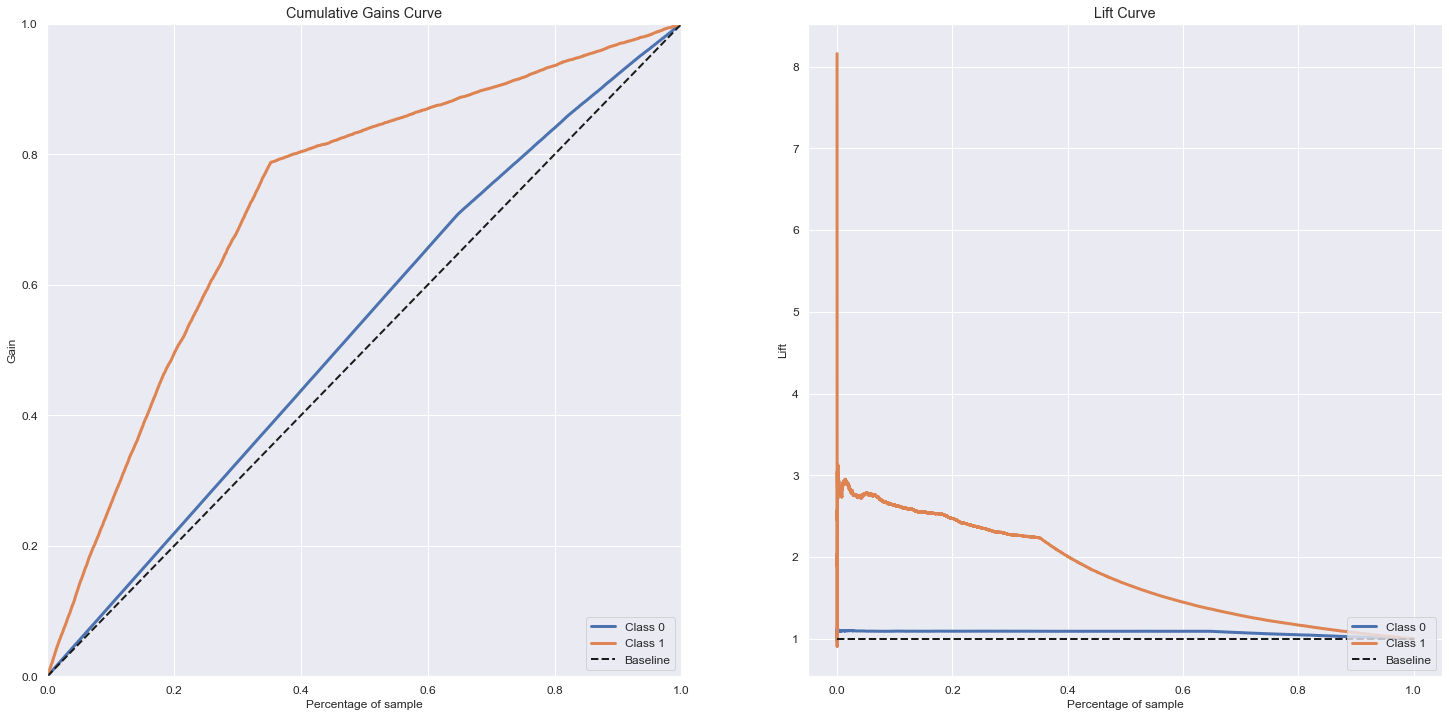

In [8]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_knn,ax=ax[1]);

In [20]:
sklearn.metrics.classification_report(y_val,yhat_knn)

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

## Linear model

In [9]:
lm_model = lm.LogisticRegression(random_state=42,n_jobs=-1)
lm_model.fit(X_train,y_train)
yhat_lm_model = lm_model.predict_proba(x_val)

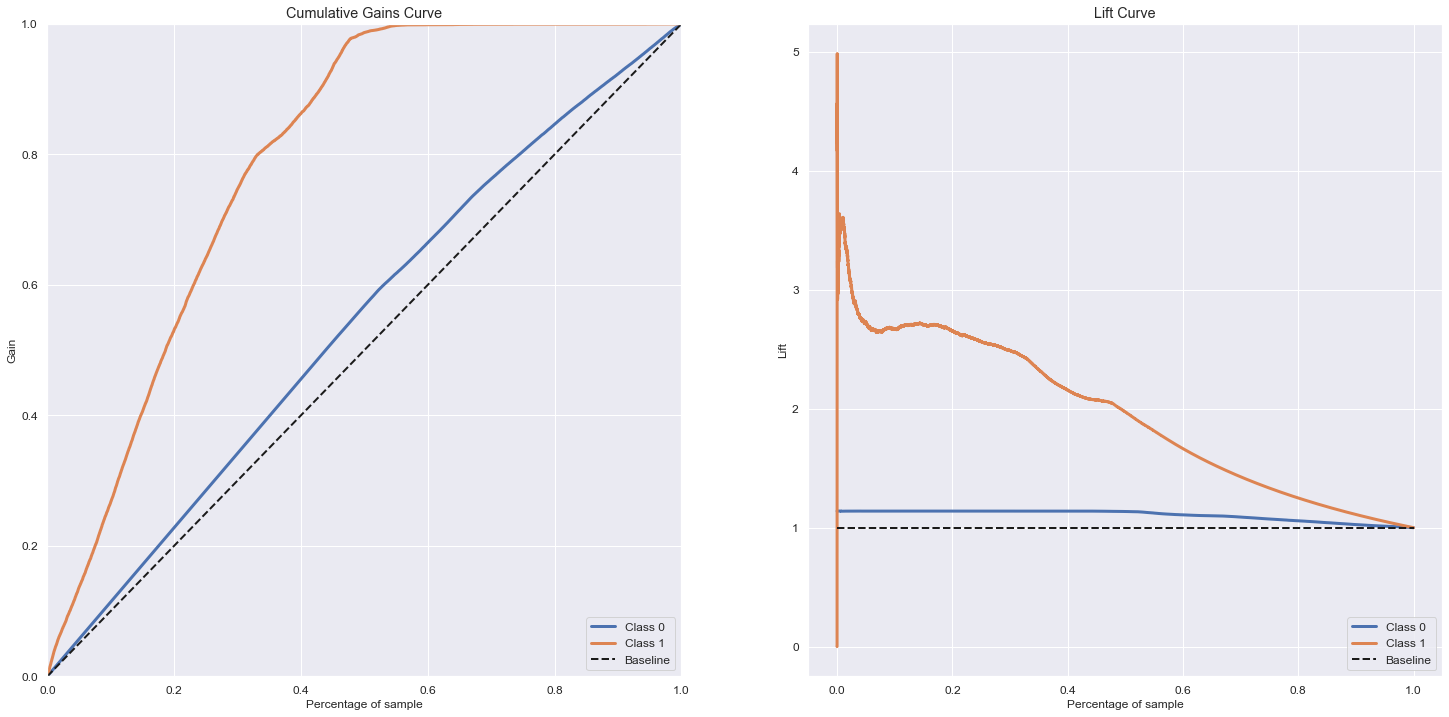

In [10]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_lm_model,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_lm_model,ax=ax[1]);

## Random forrest classifier

In [11]:
rf_model = RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
rf_model.fit(X_train,y_train)
yhat_rf_model = rf_model.predict_proba(x_val)

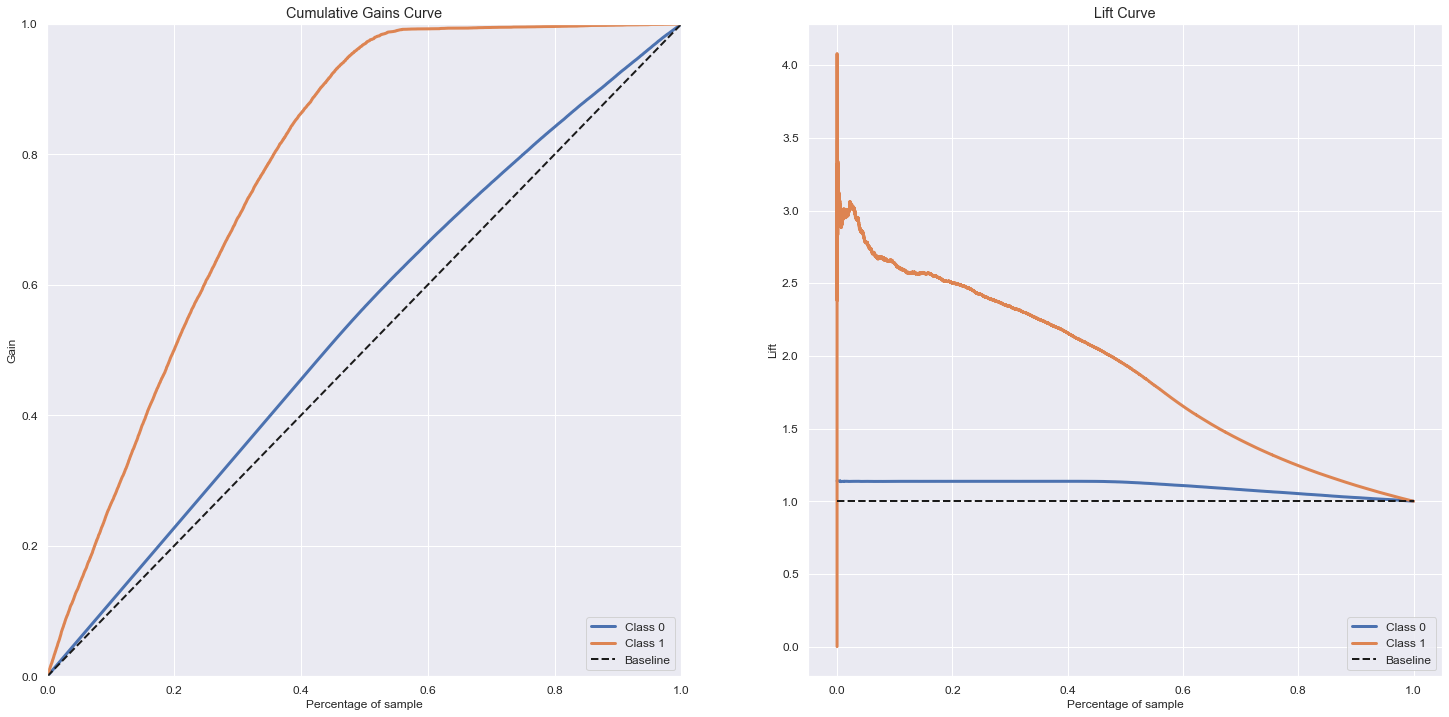

In [12]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf_model,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_rf_model,ax=ax[1]);

In [23]:
aux = rf_model.predict(x_val)

In [32]:
sklearn.metrics.precision_score(y_val,aux)

0.3282468633435063

In [33]:
sklearn.metrics.recall_score(y_val,aux)

0.20723613787197603

## Extratree classifier

In [13]:
et_model = ExtraTreesClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
et_model.fit(X_train,y_train)
yhat_et_model = et_model.predict_proba(x_val)

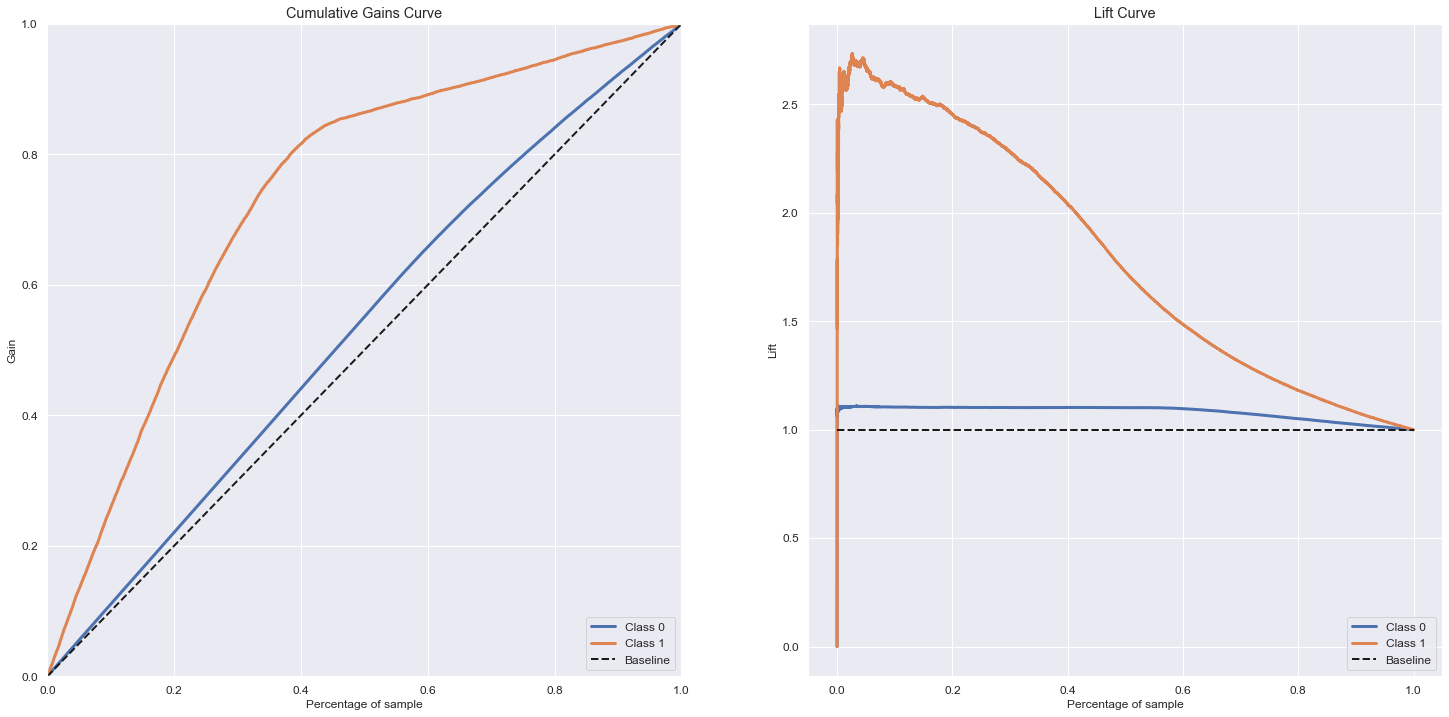

In [14]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_et_model,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_et_model,ax=ax[1]);